In [1]:
import numpy as np
import os
from sklearn.preprocessing import normalize
from pandas import read_csv
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from sklearn.metrics import classification_report

categories = ["HandOpen", "HandRest","WristExten","WristFlex"]

#Create 3d array
def create_time_series(filepath, n_timesteps):

    time_series = []
    Y = []
    first_y = True 
    first_windows = True
    for category in categories:
        print(category)
        data = np.load(filepath + "/" + category + ".npy")
        data = normalize(data, axis=1)
        windows = create_sliding_windows(data, n_timesteps)
        y_category = create_Y_for_category(category, len(windows))
        if first_y:                                        
            Y = np.array(y_category)
            first_y = False
        else:
            Y = np.vstack((Y,y_category))

        if first_windows:                                   
            time_series = windows
            first_windows = False
        else:
            time_series = np.vstack((time_series, windows))

    return time_series, Y



# Create windows of n_timesteps BY ADDING PADDING AND THEN SPLITTING THE ARRAY
def split_into_windows(X, n_timesteps):

    windows = []

    # Fill array until it can be split into windows of 10 timesteps (elements)
    while len(X) % n_timesteps != 0:
        X = np.row_stack((X, X[ len(X) -1 ]))

    windows = np.array_split(X, (len(X) / n_timesteps), axis=0)
    return np.array(windows)


#Create y data for one category
def create_Y_for_category(category, windows_length):

    indexLabel = categories.index(category)
    Y = np.full((windows_length, 1), indexLabel)
    return Y

# Create sliding windows of n_timesteps
def create_sliding_windows(data, n_timesteps):

    windows = []
    for i in range(data.shape[0] - n_timesteps):
        windows.append(data[i: i + n_timesteps])

    return np.array(windows)



#LSTM-Autoencoder Training

#Big function to extract features
def extract_features(filepath):
    n_timesteps = 15 #CHANGE TIMESTEPS HERE
    X, Y = create_time_series(filepath, n_timesteps)
    X_encoded = evaluate_AE_model(X) #Evaluate model and extract features
    return X_encoded, Y


# Create, train and evaluate model
def evaluate_AE_model(X):

    print("TRAINING LSTM AUTOENCODER")
    
    n_timesteps = X.shape[1] 
    n_features = X.shape[2]
   
    #create encoder part
    encoder_decoder = Sequential()
    encoder_decoder.add(LSTM(128, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True))
    encoder_decoder.add(LSTM(64, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True))
    encoder_decoder.add(LSTM(32, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=False))
    ## Le nombre de features extrait depend en fait du nombre de neurones du dernier layer de l encodeur 

    #create decoder part
    encoder_decoder.add(RepeatVector(n_timesteps))
    encoder_decoder.add(LSTM(32, activation='relu', return_sequences=True))
    encoder_decoder.add(LSTM(64, activation='relu', return_sequences=True))
    encoder_decoder.add(LSTM(128, activation='relu', return_sequences=True))
    encoder_decoder.add(TimeDistributed(Dense(n_features)))
    opt = keras.optimizers.Adam(learning_rate=0.001)

    n_epochs = 10
    encoder_decoder.compile(optimizer=opt, loss='mse')
    encoder_decoder.fit(X, X, epochs=n_epochs,verbose=1, batch_size=100)

    encoder_decoder.save("/content/drive/My Drive/Colab Notebooks/Essai/LSTMAE_15timesteps_10epo_sw")

    #Extract features
    encoder = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[1].output)
    X_encoded = encoder.predict(X)

    return X_encoded



# fit and evaluate LSTM
def evaluate_model(X_train, y_train, X_test, y_test):

    #Neural network

    print("TRAINING CLASSIFIER")
  
    n_timesteps = X_train.shape[1] 
    n_features = X_train.shape[2]
    n_outputs = y_train.shape[1]

    model = Sequential()
    model.add(LSTM(128, input_shape=(n_timesteps, n_features)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(n_outputs, activation="softmax"))

    opt = keras.optimizers.Adam(learning_rate=0.001)
    n_epochs = 50
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=n_epochs, batch_size=50)

    _, accuracy = model.evaluate(X_test, y_test,verbose=1)

    model.save("/content/drive/My Drive/Colab Notebooks/Essai/LSTM" + str(n_epochs) + "_" + str(accuracy * 100) + "_sw")

    print('Accuracy: %.2f' % (accuracy*100))

    y_pred = model.predict(X_test)

    y_pred = np.argmax(y_pred,axis = 1) 
    y_test = np.argmax(y_test,axis = 1)
    print(confusion_matrix(y_pred, y_test))
    print(classification_report(y_test, y_pred))

    # Old code for DNN
    # model = Sequential()
    # model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dense(256, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dense(64, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dense(32, activation='relu'))
    # model.add(Dense(y_train.shape[1], activation='softmax'))
  
   
# main function to call
def run_experiment():
    file_name = "/content/drive/My Drive/Colab Notebooks/4movementsDataset"
    X_data, Y_data = extract_features(file_name)

    Y_data = to_categorical(Y_data)

    X_train, X_test, y_train, y_test = train_test_split(
        X_data, Y_data, stratify=Y_data,test_size=0.30, random_state=42
    )

    evaluate_model(X_train, y_train, X_test, y_test)



run_experiment()
   





HandOpen
HandRest
WristExten
WristFlex
TRAINING LSTM AUTOENCODER
Epoch 1/10
 937/8400 [==>...........................] - ETA: 16:43 - loss: 0.0474

KeyboardInterrupt: ignored

In [ ]:
file_name = "/content/drive/My Drive/Colab Notebooks/4movementsDataset"
X, Y = create_time_series(file_name, 15)

HandOpen
HandRest
WristExten
WristFlex


In [ ]:
encoder_decoder = load_model("/content/drive/My Drive/Colab Notebooks/Essai 6/LSTMAE_15timesteps_10epo_sw")
X_predict = encoder_decoder.predict(X)

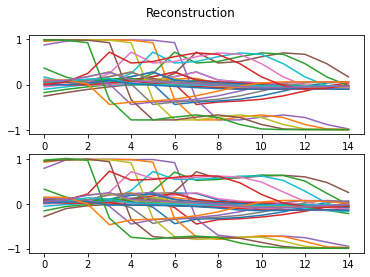

In [ ]:
fig, axs = plt.subplots(2)
fig.suptitle('Reconstruction')
for i in range(565675, 565680):
  axs[0].plot(X[i])
  axs[1].plot(X_predict[i])